### Установка и импорт всех необходимых зависимостей

In [1]:
!pip install razdel
!pip install pymorphy2
!pip install evaluate
!pip install git+https://github.com/ahmados/rusynonyms.git
!pip install natasha

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 11.4 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 7.8 MB/s eta 0:00:00
  Cloning https://github.com/ahmados/rusynonyms.git to /tmp/pip-req-build-002ya_wa
  Running command git clone --filter=blob:none --quiet https://github.com/ahmados/rusynonyms.git /tmp/pip-req-build-002ya_wa
  Resolved https://github.com/ahmados/rusynonyms.git to commit 734fdafb79bb95e4f0b40dfe68b5b3af77e17f7d
  Preparing metadata (setup.py) ... done
  Created wheel for ru-synonyms: filename=ru_synonyms-0.0.2-py3-none-any.whl size=3874263 sha256=5b912c0151b01ed1c4dd27f7b3234b9311b2749e12acedc955180cb69d88d27f
  Stored in directory: /tmp/pip-ephem-wheel-cache-0u63pyme/wheels/46/60/f3/3ad2b53fc95cf8e64b5ff87cc57bd1781a89fdbab53c5c2afe
Successfully built ru-synonyms
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 4.1 MB/s eta 0:00:0

In [2]:
import xml.etree.ElementTree as ET
import pandas as pd

import nltk
from nltk.corpus import stopwords
import re
import pymorphy2
from razdel import tokenize
from razdel import sentenize
import string
from natasha import (
    MorphVocab,
    NewsMorphTagger,
    NewsEmbedding,
    Segmenter,
    NewsSyntaxParser,
    Doc
)

import torch
import tensorflow_hub as hub
from torch import nn
from torch.utils.data import Dataset, DataLoader
import transformers
import numpy as np

from tqdm import tqdm
import os
import sys
import evaluate


nltk.download('stopwords')
nltk.download('punkt')
rus_stopwords = stopwords.words('russian')
punctuation = list(string.punctuation)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Работа с данными (kaggle)

In [3]:
datasets_folder = '/kaggle/input/data-science-work/Russian-Sentiment-Analysis-Evaluation-Datasets'
datasets = ['SentiRuEval-2015-telecoms', 'SentiRuEval-2015-banks', 'SentiRuEval-2016-banks', 'SentiRuEval-2016-telecoms']
samples = ['test.xml', 'train.xml', 'test_etalon.xml']

In [4]:
# функция для извлечения данных из xml
def extract_test(path):
    tree = ET.parse(path)
    root = tree.getroot()
    DataFrame = dict()
    database = root.findall('database')[0]
    DataFrame_columns = list()

    for idx, table in enumerate(database.findall('table')):
        for column in table.findall('column'):
            DataFrame[column.attrib['name']] = list()
            DataFrame_columns.append(column.attrib['name'])
        if idx == 0:
            break

    for table in database.findall('table'):
        for column in table.findall('column'):
            DataFrame[column.attrib['name']].append(column.text)

    data = pd.DataFrame(DataFrame, columns=DataFrame_columns)
    return data

# инициализация всех путей (kaggle)
banks_dataset = datasets[2]
path2samples = os.path.join(datasets_folder, banks_dataset)
path = os.path.join(path2samples, samples[2])
data_test = extract_test(path)
banks = ['sberbank', 'vtb', 'gazprom', 'alfabank', 'bankmoskvy', 'raiffeisen', 'uralsib', 'rshb']

In [5]:
# функция для извлечения данных из xml
def extract_train(path):
    tree = ET.parse(path)
    root = tree.getroot()
    DataFrame = dict()
    database = root.findall('database')[0]
    DataFrame_columns = list()

    for idx, table in enumerate(database.findall('table')):
        for column in table.findall('column'):
            DataFrame[column.attrib['name']] = list()
            DataFrame_columns.append(column.attrib['name'])
        if idx == 0:
            break

    for table in database.findall('table'):
        for column in table.findall('column'):
            DataFrame[column.attrib['name']].append(column.text)

    data = pd.DataFrame(DataFrame, columns=DataFrame_columns)
    return data

# инициализация всех путей (kaggle)
banks_dataset = datasets[2]
path2samples = os.path.join(datasets_folder, banks_dataset)
path = os.path.join(path2samples, samples[1])
data_train = extract_train(path)
banks = ['sberbank', 'vtb', 'gazprom', 'alfabank', 'bankmoskvy', 'raiffeisen', 'uralsib', 'rshb']

In [6]:
# функция для первичной обработки текста от лишних символов
def extract_text_features(data):
    extracted_data = dict()
    extracted_data['text'] = list()
    extracted_data['0class'] = list()
    extracted_data['1class'] = list()
    morph_rus = pymorphy2.MorphAnalyzer()

    for idx in range(len(data)):
        row = data.iloc[idx, :]
        banks_review = row[banks]
        unique_labels = set(banks_review)
        unique_labels.remove('NULL')

        # убираем все ненужные знаки
        filtered_text = re.sub('http[A-z|:|.|/|0-9]*', '', row['text']).strip()
        filtered_text = re.sub('@\S*', '', filtered_text).strip()
        filtered_text = re.sub('#', '', filtered_text).strip()
        new_text = filtered_text

        # сохраняем только уникальные токены (без придатка xml NULL)
        unique_labels = list(unique_labels)
        while len(unique_labels) < 2:
            unique_labels.append(unique_labels[-1])
        extracted_data['text'].append(new_text)
        for idx, label in enumerate(unique_labels):
            text_label = int(label) + 1
            extracted_data[f'{idx}' + 'class'].append(text_label)

    extracted_data = pd.DataFrame(extracted_data)
    
    # возвращаем dataframe
    return extracted_data

extracted_test = extract_text_features(data_test)
extracted_train = extract_text_features(data_train)

In [11]:
# пример твита из датасета
extracted_test.iloc[3308].text

'Sberbank CIB: Цены на нефть по-прежнему остаются на очень низких уровнях РБК НПЗ стремятся отложить импортные…'

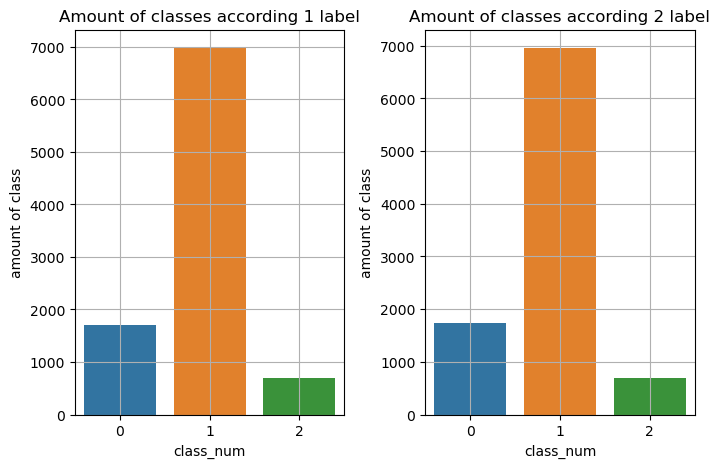

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# анализ распределения таргетов на твитах
fig, axes = plt.subplots(1, 2, figsize=(8, 5))
plt.subplots_adjust(hspace=0.15, wspace=0.3)

graph1 = sns.countplot(data=extracted_train, x='0class', ax=axes[0])
graph1.set(xlabel='class_num', ylabel='amount of class', title='Amount of classes according 1 label')
graph1.grid(True)

graph2 = sns.countplot(data=extracted_train, x='1class', ax=axes[1])
graph2.set(xlabel='class_num', ylabel='amount of class', title='Amount of classes according 2 label')
graph2.grid(True)

None

### Инициализируем модель (fine-tune) для решения нашей задачи классификации 

In [8]:
learning_rate = 1e-05
num_cls = 3

class BERTmy(torch.nn.Module):
    def __init__(self, n_classes):
        super(BERTmy, self).__init__()
        self.rubert = transformers.AutoModel.from_pretrained("DeepPavlov/rubert-base-cased-sentence")
        self.tokenizer = transformers.AutoTokenizer.from_pretrained(
            "DeepPavlov/rubert-base-cased-sentence", 
            do_lower_case=True,
            add_additional_tokens=True
        )
        
        hidden_size_output = self.rubert.config.hidden_size
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(hidden_size_output, hidden_size_output, bias=True),
            torch.nn.Dropout(0.05),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size_output, n_classes),
        )

    def forward(self, input_ids, attention_mask, token_type_ids):
        rubert_output = self.rubert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        pooled = rubert_output[1]
        output = self.classifier(pooled)

        return output
    
    def configure_optimizer(self):
        # freeze part of params
        encoder_size = 0
        for param in self.rubert._modules['encoder'].parameters():
            encoder_size += 1
        encoder_size_half = encoder_size // 2
        for idx, param in enumerate(self.rubert._modules['encoder'].parameters()):
            param.requires_grad = False
            if idx >= encoder_size_half:
                break
        
        # Adam
        optimizer = torch.optim.Adam(
            params=[
                {'params':self.rubert._modules['embeddings'].parameters(), 'lr':1e-5},
                {'params':self.rubert._modules['encoder'].parameters(), 'lr':1e-5},
                {'params':self.rubert._modules['pooler'].parameters(), 'lr':1e-5},
                {'params':self.classifier.parameters(), 'lr':1e-4}
            ],
            lr=learning_rate
        )
        # scheduler
        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer, step_size=3, gamma=0.1
        )
        
        return optimizer, scheduler

device = 'cuda' if torch.cuda.is_available() else 'cpu'
bert = BERTmy(num_cls)
if torch.cuda.is_available():
    bert = bert.cuda()
optimizer, scheduler = bert.configure_optimizer()

### Инициализируем class для нашего датасета

In [9]:
train_batch_size = 32
val_batch_size = 16
epochs = 10

class SentimentData(Dataset):
    # инициализация датасета
    def __init__(self, dataframe, tokenizer, max_len_sent, mode, col_name, split_param=0.9):
        self.mode = mode # train/test
        self.tokenizer = tokenizer # BERT BPETokenizer
        self.data = dataframe # data
        self.max_len_sent = max_len_sent # paddint to max len
        self.col_name = col_name # column for analyzing
        
        data_size = self.data.shape[0]
        if self.mode in ['val', 'train']:
            if self.mode == 'train':
                self.data = self.data.iloc[:int(data_size * split_param)]
            else:
                self.data = self.data.iloc[int(data_size * split_param):]
        
        assert self.mode in ['val', 'train', 'test']

    # для получения размера датасета
    def __len__(self):
        return self.data.shape[0]

    # для получения элемента по индексу
    def __getitem__(self, index):
        text = self.data.iloc[index][self.col_name]
        target1 = self.data.iloc[index]['0class']
        target2 = self.data.iloc[index]['1class']

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len_sent,
            pad_to_max_length=True,
            return_token_type_ids=True
        ) # pretrained tokemizer from ruBERT
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'target1': torch.tensor(target1, dtype=torch.long),
            'target2': torch.tensor(target2, dtype=torch.long)
        }

### Инициализируем наши DataLoaders

In [10]:
rubert_tokenizer = bert.tokenizer
# получение максимальной длины предложения
def get_max_len_sent(tokenizer, dataframe):
    tokens = dataframe['text'].apply(lambda x: tokenizer.tokenize(x))
    len_sent = tokens.apply(lambda x: len(x))
    return max(len_sent)
    
max_len_sent_test = get_max_len_sent(rubert_tokenizer, extracted_train)
max_len_sent_train = get_max_len_sent(rubert_tokenizer, extracted_test)

train = SentimentData(
    dataframe=extracted_train,
    tokenizer=rubert_tokenizer,
    max_len_sent=max_len_sent_train * 2,
    split_param=1.0,
    mode='train',
    col_name='text'
)

val = SentimentData(
    dataframe=extracted_train,
    tokenizer=rubert_tokenizer,
    max_len_sent=max_len_sent_train * 2,
    mode='val',
    col_name='text'
)

test = SentimentData(
    dataframe=extracted_test,
    tokenizer=rubert_tokenizer,
    max_len_sent=max_len_sent_test * 2,
    mode='test',
    col_name='text'
)

train_loader = DataLoader(train, batch_size=train_batch_size, shuffle=True)
val_loader = DataLoader(val, batch_size=val_batch_size, shuffle=False)
loaders = {
    'train': train_loader,
    'val': val_loader
}

### Дообучение модели

In [11]:
def train_model(epochs, model, loaders, optimizer, scheduler):
    # cross entropy loss
    loss_function1 = torch.nn.CrossEntropyLoss()
    loss_function2 = torch.nn.CrossEntropyLoss()
    
    # извлечение DataLoaders
    if len(loaders) > 1:
        train_loader = loaders['train']
        val_loader = loaders['val']
        steps_per_epoch = [('train', train_loader), ('val', val_loader)]
    else:
        train_loader = loaders['train']
        steps_per_epoch = [('train', train_loader)]

    # обучение по эпохам
    for epoch in range(epochs):
        for mode, loader in steps_per_epoch:
            # сохранение статистик
            train_loss = 0
            n_correct = 0
            processed_data = 0
            
            # train/val 
            if mode == 'train':
                model.train()
                requires_grad_mode = True
            else:
                model.eval()
                requires_grad_mode = False
            
            # проход по батчам
            for data in tqdm(loader):
                # обнуляем градиенты
                optimizer.zero_grad()

                # извлечение входных данных для модели
                ids = data['ids'].to(device)
                mask = data['mask'].to(device)
                token_type_ids = data['token_type_ids'].to(device)
                target1 = data['target1'].to(device)
                target2 = data['target2'].to(device)
                
                # устанавливаем необходимость вычислять/не_вычислять градиенты
                with torch.set_grad_enabled(requires_grad_mode):
                    outputs = model(ids, mask, token_type_ids)
                    preds = torch.argmax(outputs.data, dim=1)

                    # настраиваем модели на конкретный target
                    if all(target1 == target2):
                        loss1 = loss_function1(outputs, target1)
                        train_loss += loss1.item() * outputs.size(0)
                        n_correct += torch.sum(preds == target1)
                        if mode == 'train':
                            # вычисляем градиенты и обновляем веса
                            loss1.backward()
                            optimizer.step()
                    # если у твита более чем 1 метка, то настраиваем на обе
                    else:
                        loss1 = loss_function1(outputs, target1) * 0.5
                        loss2 = loss_function2(outputs, target2) * 0.5
                        loss_all = loss1 + loss2
                        train_loss += loss_all.item() * outputs.size(0)

                        mask_singular = target1 == target2
                        mask_multiple = target1 != target2
                        singular = preds[mask_singular]
                        n_correct += torch.sum(singular == target1[mask_singular])
                        multiple = preds[mask_multiple]
                        n_correct += torch.sum((multiple == target1[mask_multiple]) & (multiple == target2[mask_multiple]))
                        if mode == 'train':
                            # вычисляем градиенты и обновляем веса
                            loss_all.backward()
                            optimizer.step()     
                    processed_data += outputs.size(0)

            # вычисляем ошибку и точность прогноза на эпохе
            loader_loss = train_loss / processed_data
            loader_acc = n_correct.cpu().numpy() / processed_data
            print(f'{epoch + 1} epoch with {mode} mode has: {loader_loss} loss, {loader_acc} acc')
        
        # делаем шаг для sheduler оптмайзера
        scheduler.step()

    return model

In [ ]:
bert = train_model(epochs, bert, loaders, optimizer, scheduler)

In [ ]:
mode_process = input('Load weights? (y/n)')
if mode_process == 'n':
    torch.save(bert.state_dict(), 'bert_weights_pooled.pth')
elif mode_process == 'y':
    bert.load_state_dict(torch.load('/kaggle/input/data-science-work/bert_weights_pooled.pth'))
else:
    assert mode_process in ['n', 'y']

### Вычисление итоговых показателей

In [25]:
def calculate_accuracy(model, SentimentData):
    model.eval()
    loader = DataLoader(SentimentData, batch_size=10, shuffle=False)
    n_correct = 0
    processed_data = 0
    
    for data in tqdm(loader):
        ids = data['ids'].to(device)
        mask = data['mask'].to(device)
        token_type_ids = data['token_type_ids'].to(device)
        target1 = data['target1'].to(device)
        target2 = data['target2'].to(device)
        
        with torch.no_grad():
            outputs = model(ids, mask, token_type_ids)
            preds = torch.argmax(outputs.data, dim=1)
            mask_singular = target1 == target2
            mask_multiple = target1 != target2
            singular = preds[mask_singular]
            n_correct += torch.sum(singular == target1[mask_singular])
            multiple = preds[mask_multiple]
            if len(multiple) > 0:
                n_correct += torch.sum((multiple == target1[mask_multiple]) & (multiple == target2[mask_multiple]))
            processed_data += outputs.size(0)
        
    loader_acc = n_correct.cpu().numpy() / processed_data
    
    return loader_acc

def calculate_f1_class(model, SentimentData, class_num):
    model.eval()
    loader = DataLoader(SentimentData, batch_size=10, shuffle=False)
    true_positive = 0
    false_positive, false_negative = 0, 0
    
    for data in tqdm(loader):
        ids = data['ids'].to(device)
        mask = data['mask'].to(device)
        token_type_ids = data['token_type_ids'].to(device)
        target1 = data['target1'].to(device)
        
        with torch.no_grad():
            outputs = model(ids, mask, token_type_ids)
            
            preds = torch.argmax(outputs.data, dim=1)
            preds = preds.cpu().numpy()
            target1 = target1.cpu().numpy()
            
            mask_positive = target1 == class_num
            mask_negative = target1 != class_num
            
            true_positive += np.sum(preds[mask_positive] == class_num)
            false_positive += np.sum(preds[mask_negative] == class_num)
            false_negative += np.sum(preds[mask_positive] != class_num)
        
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)
    loader_f1 = 2 * precision * recall / (precision + recall)
    
    return loader_f1

In [ ]:
test_acc = calculate_accuracy(bert, test)
class_neg_f1 = calculate_f1_class(bert, test, 0)
class_neu_f1 = calculate_f1_class(bert, test, 1)
class_pos_f1 = calculate_f1_class(bert, test, 2)

In [ ]:
# общая accuracy и f1 по классам
test_acc, class_neg_f1, class_neu_f1, class_pos_f1

# Backdoor attacks on neural network(adversial examples)

#### USE metric for similarity between original sentence and spoiled sentence

In [40]:
def use_score(original, adversial, use_bert_encoder=False, model=None):
    from scipy.spatial.distance import cosine
    # Load pre-trained universal sentence encoder model
    if not use_bert_encoder:
        # using DAN from tensorflow
        use_encoder = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

        sentences_orig = list()
        sentences_adv = list()
        for pair in zip(original, adversial):
            orig, adv = pair
            sentences_orig.append(orig)
            sentences_adv.append(adv)

        # get embs of texts
        sentences_orig_emb = use_encoder(sentences_orig)
        sentences_adv_emb = use_encoder(sentences_adv)

        # calculate use_score with DAN
        use_scores = list()
        for pair in zip(sentences_orig_emb, sentences_adv_emb):
            orig_emb, adv_emb = pair[0], pair[1]
            use_score_one = cosine(orig_emb, adv_emb)
            use_scores.append(use_score_one)
    else:
        # using BERT itself
        model_tokenizer = model.tokenizer
        def get_inputs(text): # get inputs for model
            inputs = model_tokenizer.encode_plus(
                text,
                None,
                add_special_tokens=True,
                max_length=100,
                pad_to_max_length=True,
                return_token_type_ids=True
            )
            ids = torch.unsqueeze(
                torch.tensor(inputs['input_ids'], dtype=torch.long), 
                dim=0
            ).to(device)
            mask = torch.unsqueeze(
                torch.tensor(inputs['attention_mask'], dtype=torch.long), 
                dim=0
            ).to(device)
            token_type_ids = torch.unsqueeze(
                torch.tensor(inputs["token_type_ids"], dtype=torch.long), 
                dim=0
            ).to(device)
            
            return ids, mask, token_type_ids

        # calculate use_score with BERT
        use_scores = list()
        for pair in zip(original, adversial):
            orig, adv = pair[0], pair[1]
            orig_inputs = get_inputs(orig)
            adv_inputs = get_inputs(adv)
            orig_outputs = model.rubert(*orig_inputs)
            adv_outputs = model.rubert(*adv_inputs)
            orig_pooled, adv_pooled = orig_outputs[1], adv_outputs[1]
            orig_pooled = orig_pooled.cpu().detach().numpy()
            adv_pooled = adv_pooled.cpu().detach().numpy()
            use_score_one = cosine(orig_pooled, adv_pooled)
            use_scores.append(use_score_one)
    
    return use_scores, np.mean(use_scores)

#### char-level attacks

In [ ]:
key_errors = {
    'й': ['ц', 'ы', 'ф'],
    'ц': ['й', 'ы', 'у'],
    'у': ['ц', 'в', 'к'],
    'к': ['у', 'а', 'е'],
    'е': ['к', 'п', 'н'],
    'н': ['е', 'р', 'г'],
    'г': ['н', 'о', 'ш'],
    'ш': ['г', 'л', 'щ'],
    'щ': ['ш', 'д', 'з'],
    'з': ['щ', 'ж'],
    'х': ['ъ', 'э', 'з'],
    'ъ': ['э', 'х'],
    'ф': ['й', 'ы', 'я'],
    'ы': ['ц', 'в', 'ч', 'ф'],
    'в': ['у', 'а', 'с', 'ы'],
    'а': ['к', 'п', 'м', 'в'],
    'п': ['е', 'р', 'и', 'а'],
    'р': ['н', 'о', 'т', 'п'],
    'о': ['г', 'л', 'ь', 'р'],
    'л': ['ш', 'д', 'б', 'о'],
    'д': ['щ', 'ж', 'ю', 'л', 'б'],
    'ж': ['з', 'э', 'ю', 'д'],
    'э': ['х', 'ъ', 'ж'],
    'я': ['ф', 'ы', 'ч'],
    'ч': ['ы', 'в', 'с', 'я'],
    'с': ['в', 'а', 'м', 'ч'],
    'м': ['а', 'п', 'и', 'с'],
    'и': ['п', 'р', 'т', 'м'],
    'т': ['р', 'о', 'ь', 'и'],
    'ь': ['о', 'л', 'б', 'т'],
    'б': ['ь', 'л', 'д', 'ю'],
    'ю': ['д', 'ж', 'б'],
    'r': ['t', 'f', 'e'],
    't': ['y', 'f', 'e'],
    '0': ['9', '-'],
    '1': ['`', '2'],
    '2': ['1', '3'],
    '3': ['2', '4'],
    '4': ['3', '5'],
    '5': ['4', '6'],
    '6': ['5', '7'],
    '7': ['6', '8'],
    '8': ['7', '9'],
    '9': ['8', '0'],
    '-': ['0', '+'],
    'k': ['i', 'j', 'l', 'm'],
    '.': [',', '/', 'l', ';']
}
# получаем словарь формата: буква -> ближайшие буквы на клавиатуре

In [ ]:
# выбираем текст для генерации состязательных примеров с сохранением исходной пропорции
limit_neu = 1300
limit_pos = 270
limit_neg = 550
adversial_examples_pos = extracted_test[extracted_test['0class'] == 2]
adversial_examples_neu = extracted_test[extracted_test['0class'] == 1]
adversial_examples_neg = extracted_test[extracted_test['0class'] == 0]

adversial_examples_pos = adversial_examples_pos.head(limit_pos)
adversial_examples_neu = adversial_examples_neu.head(limit_neu)
adversial_examples_neg = adversial_examples_neg.head(limit_neg)

adversial_examples = pd.concat([adversial_examples_pos, adversial_examples_neu, adversial_examples_neg])
adversial_examples_char = adversial_examples.sample(frac=1)

print('Размер текста для генерации: ', len(adversial_examples_char))
print('Баланс классов: ')
print(np.unique(adversial_examples_char['0class'], return_counts=True))

In [ ]:
# функция для генерации состязательных примеров на уровне символов
def extract_spoiled_text_char_level(model, dataframe, 
                                    sub_chars_percent=0.15, 
                                    words2spoil=2, mode='mixed'):
    import random
    loss = torch.nn.CrossEntropyLoss() # loss function
    
    def get_inputs(model, text): # get inputs for model
        inputs = model.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=100,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = torch.unsqueeze(torch.tensor(inputs['input_ids'], dtype=torch.long), dim=0).to(device)
        mask = torch.unsqueeze(torch.tensor(inputs['attention_mask'], dtype=torch.long), dim=0).to(device)
        token_type_ids = torch.unsqueeze(torch.tensor(inputs["token_type_ids"], dtype=torch.long), dim=0).to(device)
        
        return ids, mask, token_type_ids # return input for model
    
    def extract_essential_words(model, tokens, target):
        essential_words = list()
        
        text = ' '.join(tokens)
        ids, mask, token_type_ids = get_inputs(model, text)
        outputs = model(ids, mask, token_type_ids)
        
        # calculate loss for original text
        loss_score_integral = loss(outputs.cpu(), torch.tensor([target], dtype=torch.long))

        for idx, token in enumerate(tokens):
            # get text without one token
            tokens_copy = tokens.copy()
            tokens_copy.pop(idx)
            text = ' '.join(tokens_copy)
            
            # calculate loss without current word
            ids, mask, token_type_ids = get_inputs(model, text)
            outputs = model(ids, mask, token_type_ids)
            loss_score_part = loss(outputs.cpu(), torch.tensor([target], dtype=torch.long))
            # add our score of change
            essential_words.append([token, loss_score_part.cpu().detach().numpy() - loss_score_integral.cpu().detach().numpy(), idx])
        # sort by significance using calculated loss 
        essential_words = sorted(essential_words, key=lambda x: x[1], reverse=True)
        
        return essential_words

    # функция для получения индексов букв на замену (кроме 0)
    def get_indexes2change(sub_letter):
        indexes = list()
        while len(indexes) < sub_letter:
            idx = random.randint(0, len(token) - 1)
            if idx not in indexes and idx != 0:
                indexes.append(idx)
        return indexes
    
    # фукнция для замены букв по индексам с использованием 4 типов замены:
    # del: только удаление
    # ins: только вставка
    # sub: только замена
    # mixed: все вместе сразу
    def make_token_change(indexes, token, mode='mixed'):
        # mode can be 'ins', 'del', 'sub', 'mixed'
        if mode == 'sub':
            # заменяем букву на позиции
            for idx in indexes:
                symbol = token[idx]
                try:
                    token[idx] = key_errors[symbol][random.randint(0, len(key_errors[symbol]) - 1)]
                except:
                    pass
            return ''.join(token)
        elif mode == 'ins':
            # вставляем букву на позиция и увеличиваем длину токена на 1
            ins_count = 0
            indexes = sorted(indexes)
            for idx in indexes:
                symbol = token[idx+ins_count]
                try:
                    token.insert(idx+ins_count, key_errors[symbol][random.randint(0, len(key_errors[symbol]) - 1)])
                    ins_count += 1
                except:
                    pass
            return ''.join(token)
        elif mode == 'del':
            # удаляем букву на позиция и уменьшаем длину токена на 1
            del_count = 0
            indexes = sorted(indexes)
            for idx in indexes:
                if len(token) == 1:
                    break
                symbol = token[idx-del_count]
                try:
                    token.pop(idx-del_count)
                    del_count += 1
                except:
                    pass
            return ''.join(token)
        elif mode == 'mixed':
            ins_count = 0
            del_count = 0
            # генерируем самое первое действие в слове
            idx2action = random.randint(0, 2)
            indexes = sorted(indexes)
            for idx in indexes:
                # вставляем букву на позиция и увеличиваем длину токена на 1, если ins
                # удаляем букву на позиция и уменьшаем длину токена на 1, если del
                # заменяем букву на позиции, если sub
                new_idx = idx+ins_count-del_count
                symbol = token[new_idx]
                try:
                    if idx2action == 0:
                        symbol = token[new_idx]
                        token[new_idx] = key_errors[symbol][random.randint(0, len(key_errors[symbol]) - 1)]
                        idx2action += 1
                    elif idx2action == 1:
                        token.insert(new_idx, key_errors[symbol][random.randint(0, len(key_errors[symbol]) - 1)])
                        ins_count += 1
                        idx2action += 1
                    elif idx2action == 2:
                        token.pop(new_idx)
                        del_count += 1
                        idx2action = 0 
                except:
                    pass
            return ''.join(token)
            
        assert mode in ['mixed', 'ins', 'del', 'sub']

    # precent of changes
    sub_percent = sub_chars_percent
    # spoiled texts
    text_spoiled = list()
    for text, target1, target2 in zip(dataframe['text'], dataframe['0class'], dataframe['1class']):
        # get tokens of our text
        tokens = [data.text.lower() for data in list(tokenize(text))]
        # just char
        if len(tokens) == 1:
            text_spoiled.append(' '.join(tokens))
            continue
        essential_words = extract_essential_words(model, tokens, target1)

        sub_count = 0
        tokens_spoiled = list()
        for token_set in essential_words:
            token, token_pos = token_set[0], token_set[2] # get token and token's position
            token_len = len(token)
            if token_len != 1 and sub_count < words2spoil: # no way to change
                # count our changes
                sub_letter = max(1, int(token_len * sub_percent))
                # get indexes to change
                indexes = get_indexes2change(sub_letter)
                # go through indexes
                word = make_token_change(indexes, list(token), mode=mode)
                # increase our subs
                sub_count += 1
                tokens_spoiled.append([word, token_pos])
            else:
                tokens_spoiled.append([token, token_pos])
        # organise our tokens
        tokens_spoiled = sorted(tokens_spoiled, key = lambda x: x[1])
        tokens_spoiled = [token_spoiled[0] for token_spoiled in tokens_spoiled]
        text_spoiled.append(' '.join(tokens_spoiled))
        
    return text_spoiled

### Портим текст, вычисляем показатель use_score

In [ ]:
sub_percents = [0.3, 0.4, 0.5]
spoil_modes = ['mixed', 'ins', 'del', 'sub']
amount_words2spoil = [2, 3, 4, 5]
dan_scores = dict()
bert_scores = dict()

for sub_percent in sub_percents:
    for mode in spoil_modes:
        for word2spoil in amount_words2spoil:
            if mode == 'del' and sub_percent > 0.3:
                continue
            text_spoiled = extract_spoiled_text_char_level(bert, adversial_examples_char, 
                                            sub_chars_percent=sub_percent, 
                                            words2spoil=word2spoil, mode=mode)

            adversial_examples_char[f'{mode}_{word2spoil}_{sub_percent}_textSpoiled'] = text_spoiled
        
            _, use_result_char_bert = use_score(
                adversial_examples_char['text'],
                adversial_examples_char[f'{mode}_{word2spoil}_{sub_percent}_textSpoiled'],
                use_bert_encoder=True,
                model=bert
            )
            _, use_result_char = use_score(
                adversial_examples_char['text'],
                adversial_examples_char[f'{mode}_{word2spoil}_{sub_percent}_textSpoiled']
            )

            dan_scores[f'{mode}_{word2spoil}_{sub_percent}_textSpoiled'] = use_result_char
            bert_scores[f'{mode}_{word2spoil}_{sub_percent}_textSpoiled'] = use_result_char_bert

### Вычисляем значение метрики accuracy на состязательных примерах

In [ ]:
sub_percents = [0.1, 0.2, 0.3, 0.4, 0.5]
spoil_modes = ['mixed', 'ins', 'del', 'sub']
amount_words2spoil = [2, 3, 4, 5]
adversial_scores_char = dict()

for sub_percent in sub_percents:
    for mode in spoil_modes:
        for word2spoil in amount_words2spoil:
            if mode == 'del' and sub_percent > 0.3:
                continue
            sentidata = SentimentData(
                            dataframe=adversial_examples_char,
                            tokenizer=rubert_tokenizer,
                            max_len_sent=max_len_sent_test * 2,
                            mode='test',
                            col_name=f'{mode}_{word2spoil}_{sub_percent}_textSpoiled'
                        )
            adversial_scores_char[f'{mode}_{word2spoil}_{sub_percent}_textSpoiled'] = calculate_accuracy(bert, sentidata)

### Сохраняем все результаты

In [ ]:
import csv

adversial_examples_char.to_csv('1spoiled_texts')

with open('adversial_scores.csv', 'w') as f:
    w = csv.DictWriter(f, adversial_scores_char.keys())
    w.writeheader()
    w.writerow(adversial_scores_char)
    
with open('bert_scores.csv', 'w') as f:
    w = csv.DictWriter(f, bert_scores.keys())
    w.writeheader()
    w.writerow(bert_scores)

with open('dan_scores.csv', 'w') as f:
    w = csv.DictWriter(f, dan_scores.keys())
    w.writeheader()
    w.writerow(dan_scores)

### Графики зависимостей

In [26]:
def plot_results(mode):
    import matplotlib.pyplot as plt
    amount_words2spoil = [2, 3, 4, 5]
    sub_percents = [0.1, 0.2, 0.3, 0.4, 0.5]
    fig, axes = plt.subplots(1, 2, figsize=(18, 10))
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    if mode == 'del':
        sub_percents = [0.1, 0.2, 0.3]

    for idx, word2spoil in enumerate(amount_words2spoil):
        bert_use_scores = list()
        dan_use_scores = list()
        adversial_acc = list()
        for sub_percent in sub_percents:
            col_name = f'{mode}_{word2spoil}_{sub_percent}_textSpoiled'
            adversial_acc.append(adversial_scores_char[col_name])
            dan_use_scores.append(1- dan_scores[col_name])
            bert_use_scores.append(1 - bert_scores[col_name])
            
        axes[0].plot(sub_percents, adversial_acc, label=f'{word2spoil}' + ' spoiled words')
        axes[1].plot(sub_percents, bert_use_scores, label=f'{word2spoil}' + ' spoiled words bert')
        axes[1].plot(sub_percents, dan_use_scores, label=f'{word2spoil}' + ' spoiled words dan')
        
        axes[0].grid(True)
        axes[1].grid(True)
        axes[1].legend()
        axes[1].set_xlabel('word percent to spoil')
        axes[0].set_xlabel('word percent to spoil')
        axes[1].set_ylabel('use metric score')
        axes[0].set_ylabel('bert accuracy')
        axes[1].set_title(f'Adversial {mode} testing USE score on BERT')
        axes[0].set_title(f'Adversial {mode} testing ACCURACY on BERT')
    if mode == 'del':
        usual_acc = [0.781] * 3
    else:
        usual_acc = [0.781] * 5
    axes[0].plot(sub_percents, usual_acc, label=f'original accuracy')
    axes[0].legend()
    
    plt.show()

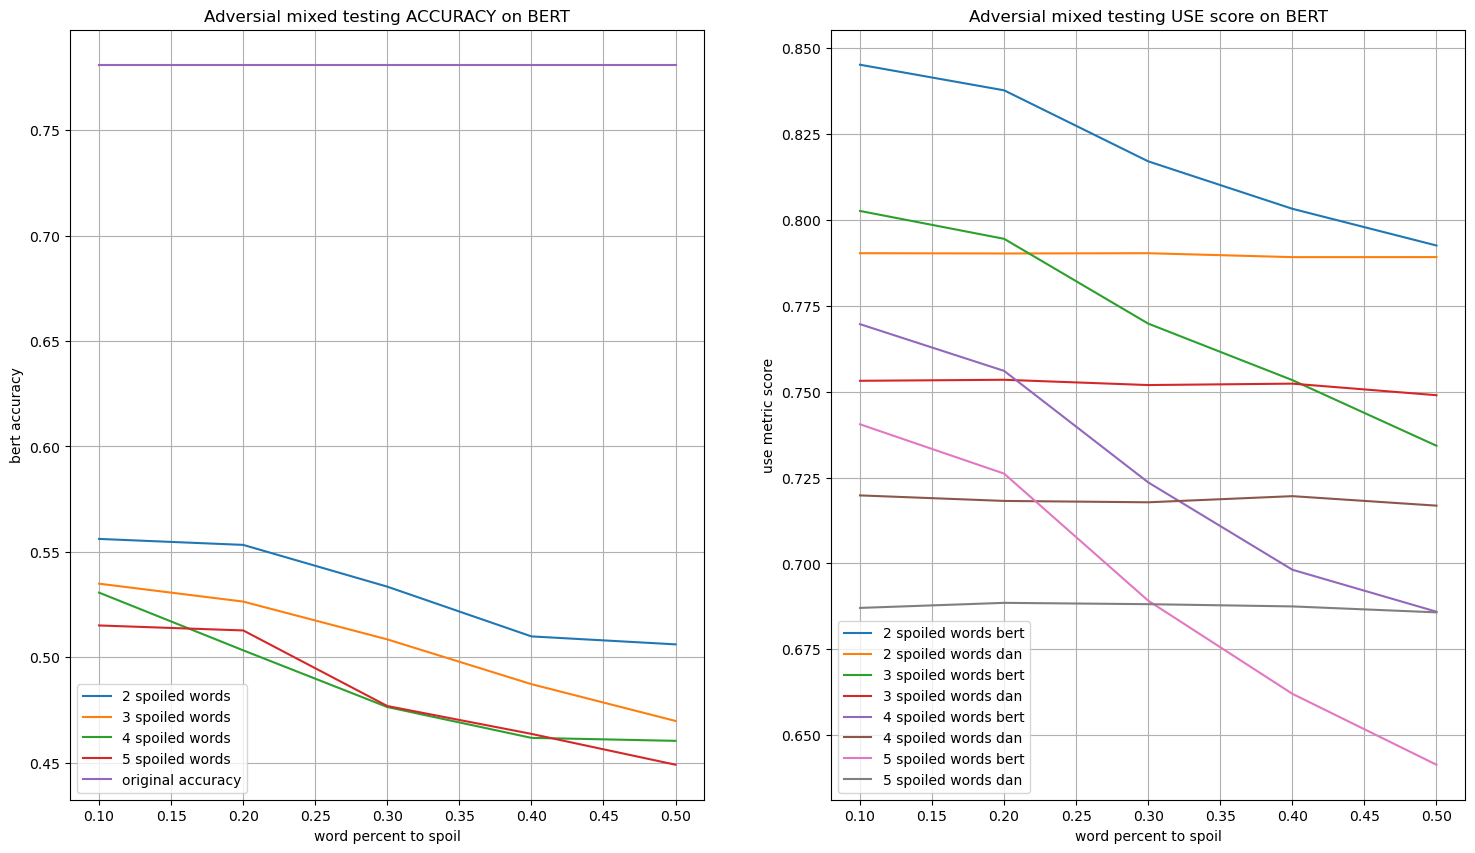

In [20]:
plot_results('mixed')

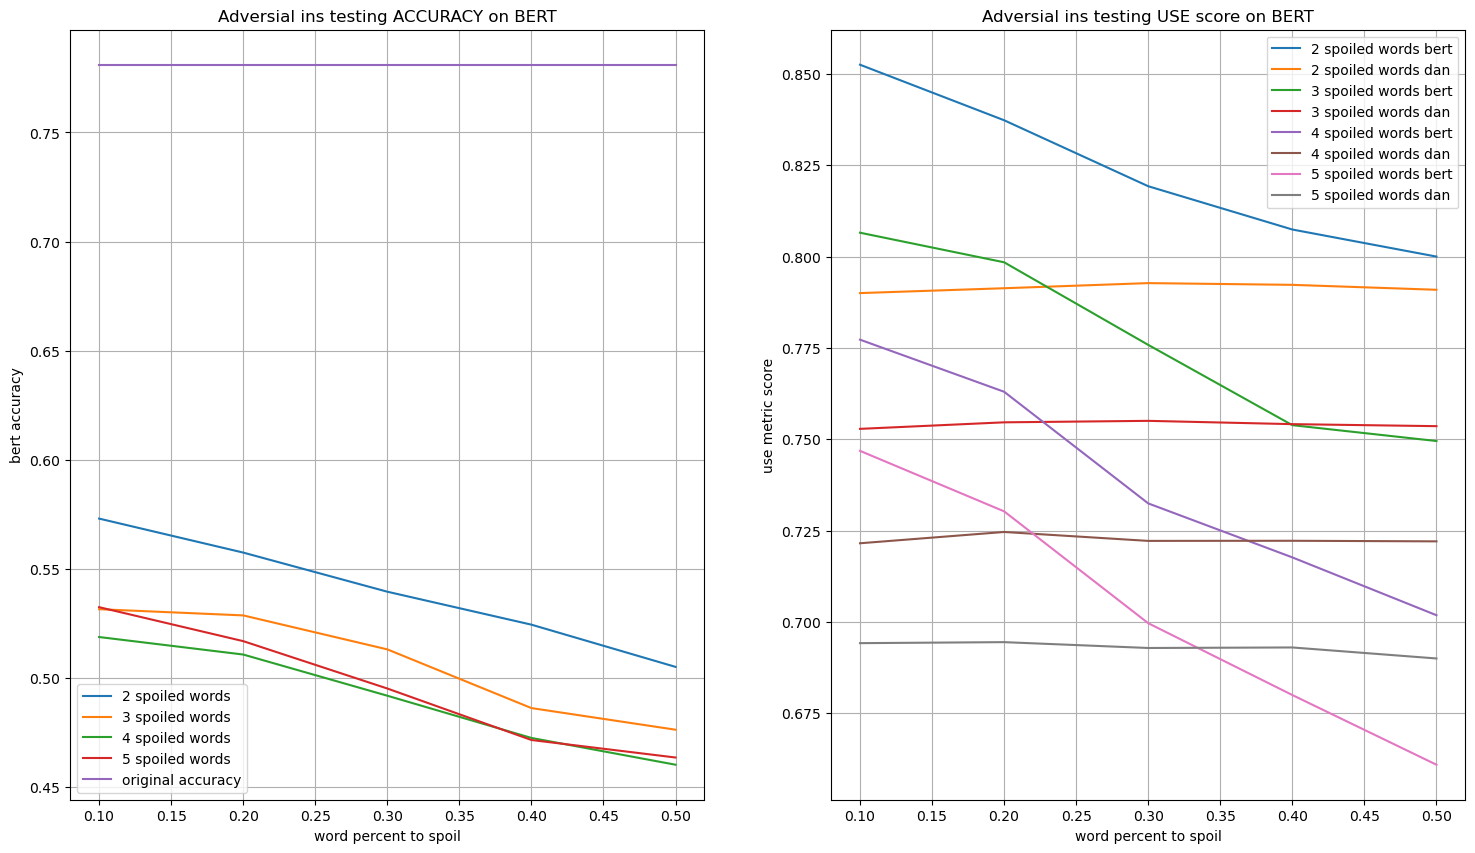

In [21]:
plot_results('ins')

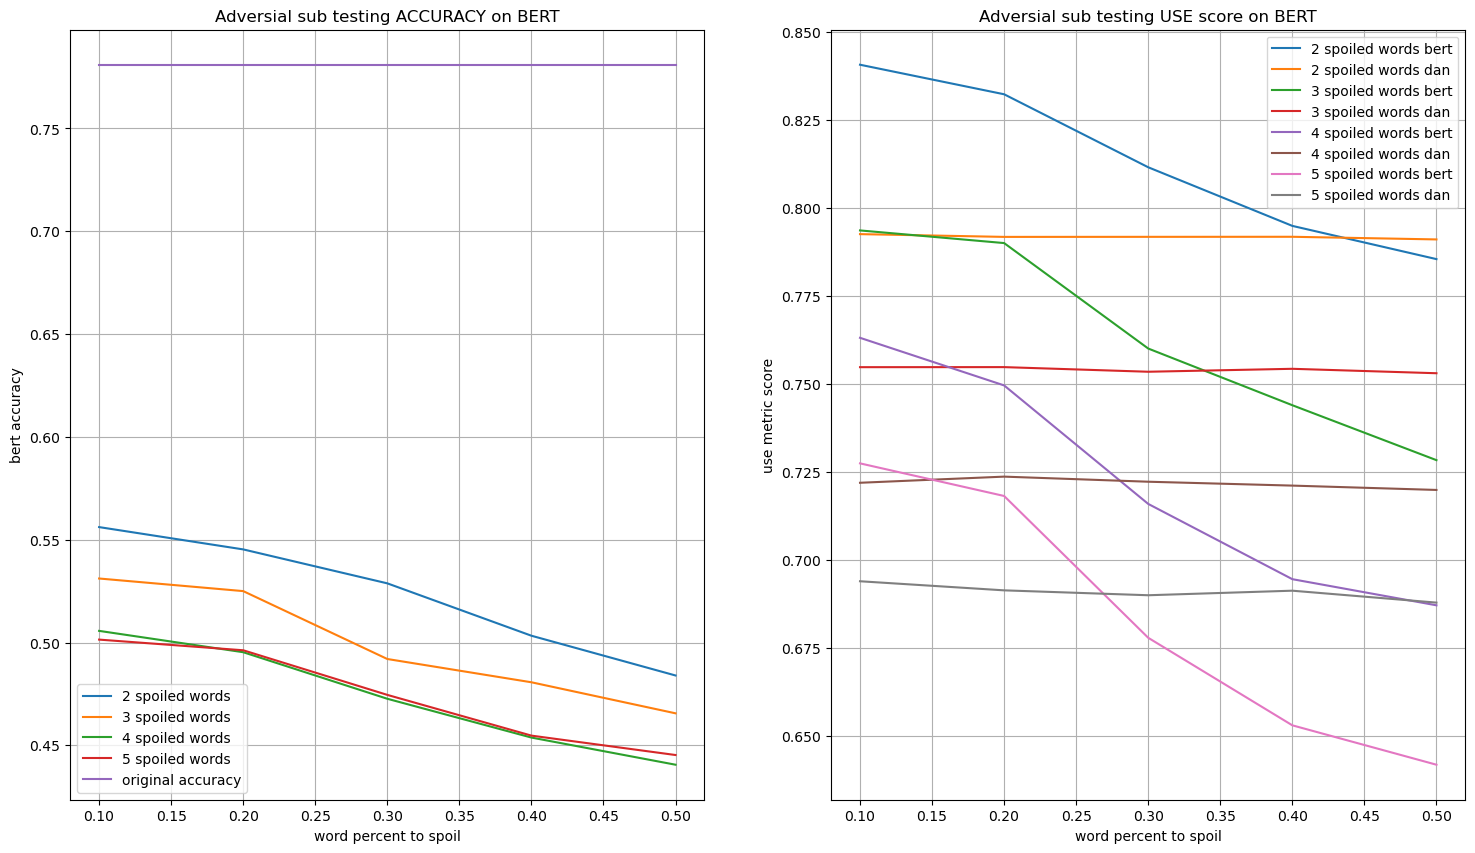

In [23]:
plot_results('sub')

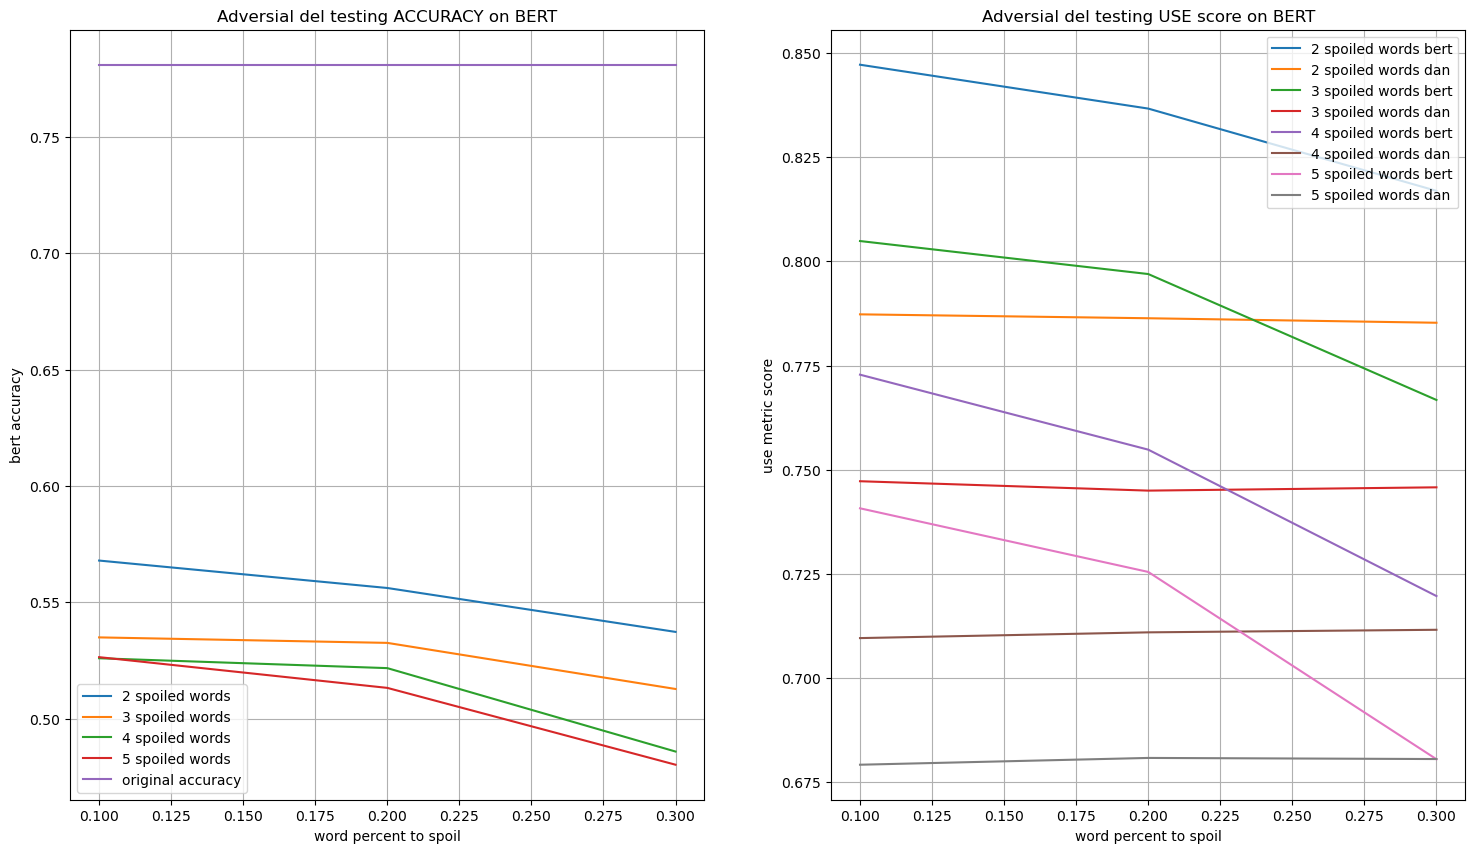

In [27]:
plot_results('del')

#### word-level attacks

In [ ]:
# подгружаем обученные word2vec rusvectors 
from gensim.downloader import load
rus_vectors = load('word2vec-ruscorpora-300')

# датасет для генерации порчи уровня слов
adversial_examples_word = extracted_test

In [ ]:
# функция для генерации порчи уровня слов
def extract_spoiled_text_word_level(dataframe, wordlen=2, dist2synonym=0, word2subs=1):
    from ru_synonyms import SynonymsGraph
    sg = SynonymsGraph()
    
    tokens2change = list()
    # морфологический анализатор
    morph = pymorphy2.MorphAnalyzer()
    # natasha's embs
    emb = NewsEmbedding()
    # natasha's morph tagger
    morph_tagger = NewsMorphTagger(emb)
    # natasha's segmenter
    segmenter = Segmenter()
    
    source_text = dataframe['text']
    for row in source_text:
        sub_words_amount = 0
        word_subs = list()
        # инициализация natasha's Doc
        row_text = Doc(row)
        row_text.segment(segmenter)
        row_text.tag_morph(morph_tagger)

        for token in row_text.tokens:
            if len(token.text) > wordlen and sub_words_amount < word2subs:
                # получаем токен
                word2change = token.text
                # получаем лемматизированное слово
                normal_form_word = morph.parse(word2change)[0].normal_form
                # получаем его часть речи
                word_tag = token.pos
                # делаем ключ для поиска в rusvectors
                rus_vectores_word = normal_form_word + f'_{word_tag}'
                try:
                    # пытаемся найти синоним
                    synonyms = rus_vectors.most_similar(rus_vectores_word, topn=500)
                    counter = dist2synonym
                    # ищем синоним с учетом части речи и близости по косинусной метрики
                    for synonym in synonyms:
                        synonym_tag = synonym[0].split('_')[1]
                        if synonym_tag == word_tag:
                            if counter == 0:
                                word_synonym = synonym[0]
                                break
                            counter -= 1
                    try:
                        start = token.start
                    except:
                        start = 0
                    end = token.stop
                    # сохраняем синоним, его начало и конец
                    word_subs.append((start, end, word_synonym))
                    sub_words_amount += 1
                except:
                    # не нашли синоним
                    pass
        for token in row_text.tokens:
            # пытыаемся найти синоним, используя граф знаний RuWordNet
            if len(token.text) > wordlen and sub_words_amount < word2subs:
                word2change = token.text
                normal_form_word = morph.parse(word2change)[0].normal_form
                try:
                    # нашли синоним
                    if sg.is_in_dictionary(normal_form_word):
                        gen = sg.get_list(normal_form_word)
                        for i in range(dist2synonym + 1):
                            synonym = next(gen)
                        try:
                            start = token.start
                        except:
                            start = 0
                        end = token.stop
                        word_subs.append((start, end, synonym))
                        sub_words_amount += 1
                except:
                    # не нашли синоним
                    pass
        # заполняем пропусками, если не смогли заменить достаточно слов
        while len(word_subs) < word2subs:
            word_subs.append(None)
        tokens2change.append(word_subs)
    
    dataframe[f'{word2subs}_{dist2synonym + 1}_subword'] = tokens2change
    
    return dataframe

In [ ]:
# генерация состязательных примеров
word_changes = [1, 2, 3]
positions = [0, 1, 2, 3, 4, 5, 6]
idx = 0
for change_amount in word_changes:
    for synonym_pos in positions:
        tqdm.write(f'iteration::{idx}')
        idx += 1
        adversial_examples_word = extract_spoiled_text_word_level(
            adversial_examples_word,
            dist2synonym=synonym_pos,
            word2subs=change_amount
        )

# сохраянем состязательные примеры
adversial_examples_word.to_csv('spoiled_text_word.csv')

In [ ]:
# получаем нужные названия колонок
columns = list(adversial_examples_word.columns)
columns.remove('0class')
columns.remove('1class')
columns.remove('text')

In [ ]:
# очищаем ненужные символы, появивщиеся при замене
def clean_up_synonym(row):
    row_list = eval(row)
    new_synonyms = list()
    for part in row_list:
        if not part is None:
            synonym = part[2]
            synonym = synonym.split('_')[0]
            synonym_parts = synonym.split('::')
            if len(synonym_parts) > 1:
                synonym = synonym_parts[1]
            else:
                synonym = synonym_parts[0]
            new_synonyms.append((part[0], part[1], synonym))
        else:
            new_synonyms.append(None)

    return new_synonyms
        
for column in columns:
    adversial_examples_word[column] = adversial_examples_word[column].apply(clean_up_synonym)

In [ ]:
# импортируем предобученный BERT для задачи MLM
from transformers import AutoTokenizer, AutoModelForMaskedLM

MLM_tokenizer = AutoTokenizer.from_pretrained("ai-forever/ruBert-large")
MLM = AutoModelForMaskedLM.from_pretrained("ai-forever/ruBert-large").cuda()

In [ ]:
# функция для добавления окончания лемматизированного синонима
def extract_mask_from_synonyms(dataframe, col_name, iter2find=5, len2sep=2):
    from copy import deepcopy
    spoiled_subs_ended = list()
    
    # получения выхода MLM модели от токенизированного текста с добавлением [MASK]
    def pass_the_model(part_lemmatized_sent, return_prob=False):
        inputs = MLM_tokenizer(part_lemmatized_sent, return_tensors='pt')
        ids = inputs['input_ids'].to(device)
        mask = inputs['attention_mask'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        mask_token_index = (inputs.input_ids == MLM_tokenizer.mask_token_id)[0].nonzero(as_tuple=True)[0]

        with torch.no_grad():
            logits = MLM(
                input_ids=ids,
                attention_mask=mask,
                token_type_ids=token_type_ids
            ).logits
        
        logits = logits.cpu().detach()
        logits_mask = torch.squeeze(logits[0, mask_token_index], dim=0)
        # получение вероятностей
        probs = torch.nn.functional.softmax(logits_mask, dim=0)
        predicted_token_id = probs.argmax(axis=-1)
        # очищаем ненужную часть от BPETokenizer
        new_token = MLM_tokenizer.decode(predicted_token_id).replace('#', '')
        
        if return_prob:
            # если нужно вернуть вероятность токена
            token_prob = probs[probs.argmax(axis=-1)]
            return new_token, token_prob
        else:
            return new_token
    
    substitutions = dataframe[col_name]
    original_text = dataframe['text']
    for possible_sub, text in tqdm(zip(substitutions, original_text)):
        substitutions_ended = list()
        for part in possible_sub:
            if part is None:
                # если не все слова были заменены
                continue
            # получаем синоним и токены твита
            synonym = part[2]
            start, stop = part[0], part[1]
            word_tokens = MLM_tokenizer.tokenize(synonym)
            word_tokens = [token.replace('#', '') for token in word_tokens]
            # если BPETokenizer разбил токена на замену на более чем 1 часть
            if len(word_tokens) > 1:
                # заменяем последнюю лексему слова на [MASK] и предсказываем
                word_tokens[-1] = '[MASK]'
                new_word = ''.join(word_tokens)
            
                text_copy = list(deepcopy(text))
                text_copy[start:stop] = new_word
            
                new_token = pass_the_model(''.join(text_copy))
            
                word_tokens[-1] = new_token.replace('#', '')
                substitutions_ended.append((start, stop, ''.join(word_tokens)))
            # если BPETokenizer разбил токена на замену на 1 часть
            else:
                initial_synonym = synonym
                tokens_prob = list()
                # each iteration delete one symbol and predict ending
                for i in range(iter2find):
                    word_tokens = list(initial_synonym)
                    # if there is no symbols to delete more
                    if len(word_tokens) < i + 2:
                        break
                    for j in range(i):
                        word_tokens.pop(-1)
                    word_tokens.append('[MASK]')
                    new_word = ''.join(word_tokens)

                    text_copy = list(deepcopy(text))
                    text_copy[start:stop] = new_word

                    new_token, token_prob = pass_the_model(''.join(text_copy), True)

                    tokens_prob.append((new_token, token_prob, i))
                # sorted by the most possible token
                tokens_prob = sorted(tokens_prob, key=lambda x: x[1], reverse=True)

                # выбираем окончание с наибольшей вероятнсотью и заменяем i последних симболов на него
                if len(tokens_prob) > 0: 
                    symbols2delete = tokens_prob[0][2]
                    initial_synonym = list(initial_synonym)
                    for i in range(symbols2delete):
                        initial_synonym.pop(-1)
                    initial_synonym.extend(tokens_prob[0][0].replace('#', ''))
                    substitutions_ended.append((start, stop, ''.join(initial_synonym)))
                else:
                    substitutions_ended.append((start, stop, initial_synonym))

        spoiled_subs_ended.append(substitutions_ended)
        
    return spoiled_subs_ended

In [ ]:
# генерация окончаний
for idx, column in enumerate(columns):
    tqdm.write(f'iteration::{idx + 1}')
    adversial_examples_word[column + f'_ended'] = extract_mask_from_synonyms(adversial_examples_word, column)

# сохраянем испорченный текст с окончаниями
adversial_examples_word.to_csv('spoiled_words_with_endings_non_separated.csv')

In [ ]:
# функция для замены
def sub_source_text(source, subs):
    text_sub = list()
    for orig, changes in zip(source, subs):
        orig = list(orig)
        move = 0
        changes_sorted = sorted(changes, key=lambda x:x[0])
        for change in changes_sorted:
            start, stop = change[0], change[1]
            synonym_ended = change[2]
            orig[start + move:stop + move] = synonym_ended
            move += (len(synonym_ended) - (stop-start))
        text_sub.append(''.join(orig))
    
    return text_sub

# делаем замену и вычисляем use_scores
bert_scores = dict()
dan_scores = dict()
word_changes = [1, 2, 3]
positions = [0, 1, 2, 3, 4, 5, 6]
source = 'text'
for column in tqdm(columns):
    col_name = column + f'_ended'
    subs = adversial_examples_word[col_name]
    source_text = adversial_examples_word[source]
    
    text_sub = sub_source_text(source_text, subs)
    adversial_examples_word[column + f'spoiled_text'] = text_sub
    
    _, use_result_word_bert = use_score(
        adversial_examples_word['text'],
        adversial_examples_word[column + f'spoiled_text'],
        use_bert_encoder=True,
        model=bert
    )
    _, use_result_word = use_score(
        adversial_examples_word['text'],
        adversial_examples_word[column + f'spoiled_text']
    )
    
    dan_scores[column + f'spoiled_text'] = use_result_word
    bert_scores[column + f'spoiled_text'] = use_result_word_bert

In [ ]:
# вычисляем accuracy на состязательных примерах
word_changes = [1, 2, 3]
positions = [0, 1, 2, 3, 4, 5, 6]
adversial_scores_word = dict()

for idx, column in enumerate(columns):
    tqdm.write(f'iteration::{idx + 1}')
    col_name = column + f'spoiled_text'
    sentidata = SentimentData(
                    dataframe=adversial_examples_word,
                    tokenizer=rubert_tokenizer,
                    max_len_sent=max_len_sent_test * 2,
                    mode='test',
                    col_name=col_name
                )
    adversial_scores_word[col_name] = calculate_accuracy(bert, sentidata)

In [36]:
# графики зависимостей
def plot_results_word():
    import matplotlib.pyplot as plt
    positions = [1, 2, 3, 4, 5, 6, 7]
    word2change = [1, 2, 3]
    fig, axes = plt.subplots(1, 2, figsize=(18, 10))
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    for amount_changes in word2change:
        bert_use_scores = list()
        dan_use_scores = list()
        adversial_acc = list()
        for position in positions:
            col_name = f'{amount_changes}_{position}_subwordspoiled_text'
            bert_use_scores.append(1 - bert_scores[col_name])
            dan_use_scores.append(1- dan_scores[col_name])
            adversial_acc.append(adversial_scores_word[col_name])
            
        axes[0].plot(positions, adversial_acc, label=f'{amount_changes}' + ' spoiled words')
        axes[1].plot(positions, bert_use_scores, label=f'{amount_changes}' + ' spoiled words bert')
        axes[1].plot(positions, dan_use_scores, label=f'{amount_changes}' + ' spoiled words dan')
        
        axes[0].grid(True)
        axes[1].grid(True)
        axes[1].legend()
        axes[0].legend()
        axes[1].set_xlabel('word amount to spoil')
        axes[0].set_xlabel('word amount to spoil')
        axes[1].set_ylabel('use metric score')
        axes[0].set_ylabel('bert accuracy')
        axes[1].set_title(f'Adversial examples testing USE score on BERT')
        axes[0].set_title(f'Adversial examples testing ACCURACY on BERT')
    usual_acc = [0.781] * 7
    axes[0].plot(positions, usual_acc, label=f'original accuracy')
    axes[0].legend()
    
    plt.show()

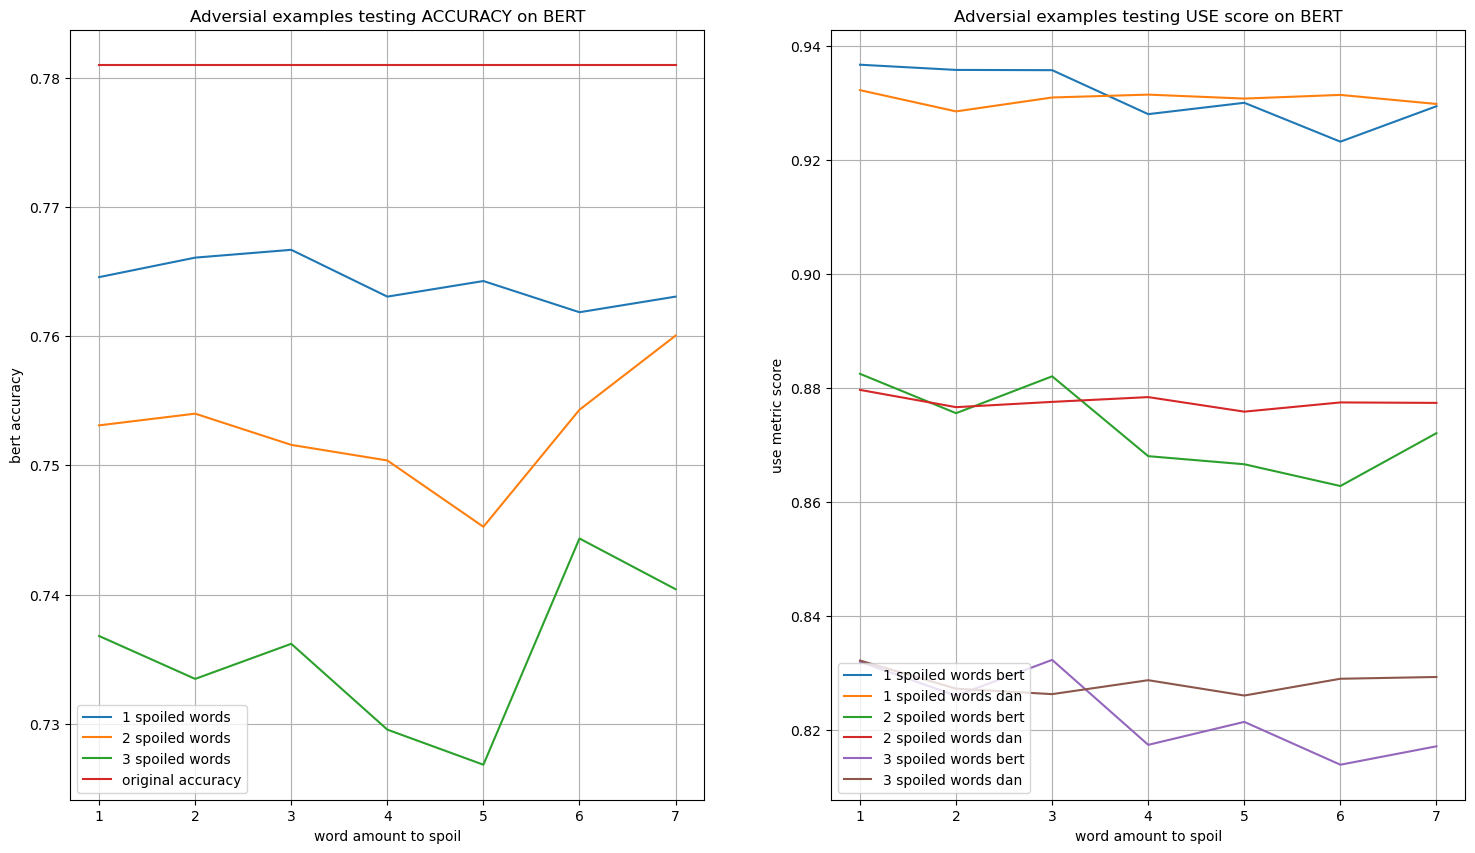

In [37]:
plot_results_word()

In [ ]:
# сохраняем все покаатели и состязательные примеры

import csv

with open('adversial_scores_word.csv', 'w') as f:
    w = csv.DictWriter(f, adversial_scores_word.keys())
    w.writeheader()
    w.writerow(adversial_scores_word)
    
with open('bert_scores_word.csv', 'w') as f:
    w = csv.DictWriter(f, bert_scores.keys())
    w.writeheader()
    w.writerow(bert_scores)
    
with open('dan_scores_word.csv', 'w') as f:
    w = csv.DictWriter(f, dan_scores.keys())
    w.writeheader()
    w.writerow(dan_scores)

#### OrderBkd

In [36]:
def order_bkd_extract(dataframe, col_name):
    order_spoiled_text = list()
    # союзы, наречия и предлоги
    special_units = ['CCONJ', 'SCONJ', 'PRON', 'ADV']
    # natasha's embs
    emb = NewsEmbedding()
    # морфологический анализатор
    morph_vocab = MorphVocab()
    # natasha's morph tagger
    morph_tagger = NewsMorphTagger(emb)
    # natasha's syntax parser
    syntax_parser = NewsSyntaxParser(emb)
    # natasha's segmenter
    segmenter = Segmenter()
    main_id = '1_0'
    source = dataframe[col_name]
    
    for idx in tqdm(range(len(source))):
        text = source.iloc[idx]
        # инициализация natasha's Doc
        doc_text = Doc(text)
        doc_text.segment(segmenter)
        doc_text.tag_morph(morph_tagger)
        doc_text.parse_syntax(syntax_parser)
        non_morphological_token = None
        morphological_dependece = None
        for token in doc_text.tokens:
            # лемматизированное слово
            token.lemmatize(morph_vocab)
            pos_tag = token.pos
            # если специальное слово и мы его еще не нашли
            if pos_tag in special_units and non_morphological_token is None:
                try:
                    non_morphological_token = (token.start, token.stop, token.text)
                except:
                    non_morphological_token = (0, token.stop, token.text)
            # если еще не нашли слово с морфологической зависимостью
            elif morphological_dependece is None:
                lower_token = token.text.lower()
                token_head_id = token.head_id
                token_id = token.id
                token_lemma = token.lemma
                # если у слова есть морфологическая зависимость
                if lower_token != token_lemma and token_id != token_head_id and token_head_id != main_id:
                    try:
                        morphological_dependece = (token.start, token.stop, token.text)
                    except:
                        morphological_dependece = (0, token.stop, token.text)
        # если нашли 2 слова на замену друг другу
        if not morphological_dependece is None and not non_morphological_token is None:
            text_symbols = list(text)
            start_dep, stop_dep = morphological_dependece[0], morphological_dependece[1]
            token_dep = morphological_dependece[2]
            start_non, stop_non = non_morphological_token[0], non_morphological_token[1]
            token_non = non_morphological_token[2]
            
            # меняем их местами
            start_less = start_non if start_non < start_dep else start_dep
            start_greater = start_dep if start_non < start_dep else start_non
            
            stop_less = stop_non if start_non < start_dep else stop_dep
            stop_greater = stop_dep if start_non < start_dep else stop_non
            
            token_less = token_non if start_non < start_dep else token_dep
            token_greater = token_dep if start_non < start_dep else token_non
            
            text_symbols[start_less:stop_less] = token_greater
            diff = len(token_greater) - (stop_less - start_less)
            text_symbols[start_greater + diff:stop_greater + diff] = token_less
            order_spoiled_text.append(''.join(text_symbols))
        else:
            # если не нашли
            order_spoiled_text.append(text)
    
    return order_spoiled_text

In [37]:
# генерация состязательных примеров
adversial_examples_order = extracted_test
adversial_examples_order['order_spoiled_text'] = order_bkd_extract(adversial_examples_order, 'text')

# оставляем только те, которые были изменены
mask = adversial_examples_order['order_spoiled_text'] != adversial_examples_order['text']
only_spoiled_text = adversial_examples_order[mask]

100%|██████████| 3313/3313 [00:36<00:00, 90.33it/s] 


In [42]:
# показатели use_metric
_, use_result_order_bert = use_score(
    only_spoiled_text['text'],
    only_spoiled_text['order_spoiled_text'],
    use_bert_encoder=True,
    model=bert
)
_, use_result_order = use_score(
    only_spoiled_text['text'],
    only_spoiled_text['order_spoiled_text']
)

use_result_order_bert, use_result_order

In [44]:
# вычисляем accuracy на испорченном датасете
sentidata = SentimentData(
                dataframe=adversial_examples_order,
                tokenizer=rubert_tokenizer,
                max_len_sent=max_len_sent_test * 2,
                mode='test',
                col_name='order_spoiled_text'
            )
adversial_score_order = calculate_accuracy(bert, sentidata)

# вычисляем accuracy на исходном датасете
sentidata = SentimentData(
                dataframe=adversial_examples_order,
                tokenizer=rubert_tokenizer,
                max_len_sent=max_len_sent_test * 2,
                mode='test',
                col_name='text'
            )
adversial_score_test = calculate_accuracy(bert, sentidata)

100%|██████████| 332/332 [00:14<00:00, 23.39it/s]


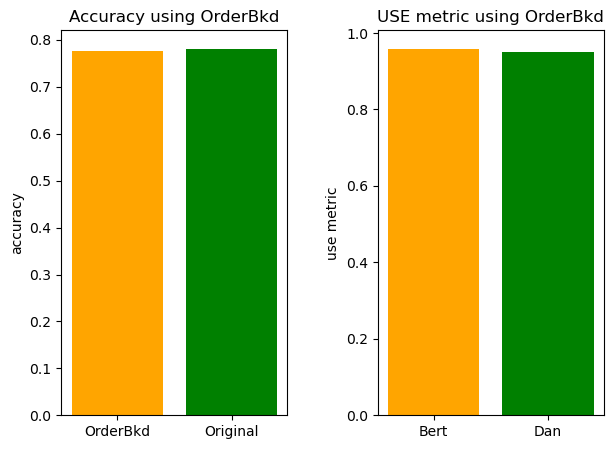

In [46]:
# результаты данного способа генерации
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(1, 2, figsize=(7, 5))
plt.subplots_adjust(wspace=0.4, hspace=0.05)

axes[0].bar(['OrderBkd', 'Original'], [adversial_score_order, adversial_score_test], color=['orange', 'green'])
axes[0].set_ylabel('accuracy')
axes[0].set_title('Accuracy using OrderBkd')
axes[1].bar(['Bert', 'Dan'], [1 - use_result_order_bert, 1 - use_result_order], color=['orange', 'green'])
axes[1].set_ylabel('use metric')
axes[1].set_title('USE metric using OrderBkd')

plt.show()